## Dependencies

In [1]:
# !pip install --quiet efficientnet
!pip install --quiet image-classifiers

In [2]:
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
# import efficientnet.tfkeras as efn
from classification_models.tfkeras import Classifiers
import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

REPLICAS:  1


# Model parameters

In [4]:
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 64,
  "EPOCHS": 25,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'resnet18',
  "BASE_MODEL_WEIGHTS": 'imagenet',
  "DATASET_PATH": 'melanoma-256x256'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'HEIGHT': 256,
 'WIDTH': 256,
 'CHANNELS': 3,
 'BATCH_SIZE': 64,
 'EPOCHS': 25,
 'LEARNING_RATE': 0.0003,
 'ES_PATIENCE': 10,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 25,
 'BASE_MODEL': 'resnet18',
 'BASE_MODEL_WEIGHTS': 'imagenet',
 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [5]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = KaggleDatasets().get_gcs_path(config['DATASET_PATH'])
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [6]:
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .6:
        if p_spatial2 >= .9:
            image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'], 180.)
        elif p_spatial2 >= .8:
            image['input_image'] = transform_zoom(image['input_image'], config['HEIGHT'], 8., 8.)
        elif p_spatial2 >= .7:
            image['input_image'] = transform_shift(image['input_image'], config['HEIGHT'], 8., 8.)
        else:
            image['input_image'] = transform_shear(image['input_image'], config['HEIGHT'], 2.)
        
    if p_crop >= .6: # crops
        if p_crop >= .8:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.8)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    if p_pixel >= .6: # Pixel-level transforms
        if p_pixel >= .9:
            image['input_image'] = tf.image.random_hue(image['input_image'], 0.01)
        elif p_pixel >= .8:
            image['input_image'] = tf.image.random_saturation(image['input_image'], 0.7, 1.3)
        elif p_pixel >= .7:
            image['input_image'] = tf.image.random_contrast(image['input_image'], 0.8, 1.2)
        else:
            image['input_image'] = tf.image.random_brightness(image['input_image'], 0.1)

    return image, label

## Auxiliary functions

In [7]:
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.normal([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.normal([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shift(image, height, h_shift, w_shift):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = h_shift * tf.random.normal([1],dtype='float32') 
    width_shift = w_shift * tf.random.normal([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_zoom(image, height, h_zoom, w_zoom):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly zoomed
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_zoom = 1.0 + tf.random.normal([1],dtype='float32')/h_zoom
    width_zoom = 1.0 + tf.random.normal([1],dtype='float32')/w_zoom
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(zoom_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

## Learning rate scheduler

In [8]:
lr_min = 1e-6
# lr_start = 0
lr_max = config['LEARNING_RATE']
steps_per_epoch = 24844 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
# hold_max_steps = 0
# step_decay = .8
# step_size = steps_per_epoch * 1

# rng = [i for i in range(0, total_steps, 32)]
# y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
#                                warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
#                                lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

# sns.set(style="whitegrid")
# fig, ax = plt.subplots(figsize=(20, 6))
# plt.plot(rng, y)
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [9]:
# Initial bias
pos = len(k_fold[k_fold['target'] == 1])
neg = len(k_fold[k_fold['target'] == 0])
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(k_fold)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
584
32542
[-4.02038586]
Class weight
{0: 0.5089730194825148, 1: 28.36130136986301}


In [10]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    BaseModel, preprocess_input = Classifiers.get(config['BASE_MODEL'])
    base_model = BaseModel(input_shape=input_shape, 
                           weights=config['BASE_MODEL_WEIGHTS'], 
                           include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output', 
                     bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [11]:
# Evaluation
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Resample dataframe
k_fold = k_fold[k_fold['image_name'].isin(image_names)]

# Test
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))

test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
test_image_data = test_dataset.map(lambda data, image_name: data)


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
#         tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_auc', mode='max', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint(model_path, monitor='val_auc', mode='max', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            optimizer = tfa.optimizers.RectifiedAdam(lr=lr_max,
                                                     total_steps=total_steps,
                                                     warmup_proportion=(warmup_steps / total_steps),
                                                     min_lr=lr_min)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch,
                            callbacks=[checkpoint, es],
                            class_weight=class_weight, 
                            verbose=2).history

        # save last epoch weights
        model.save_weights('last_' + model_path)

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print(f'Last model inference (TTA {config["TTA_STEPS"]} steps)...')
        for step in range(config['TTA_STEPS']):
            test_preds_last += model.predict(test_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(model_path)
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print(f'Best model inference (TTA {config["TTA_STEPS"]} steps)...')
        for step in range(config['TTA_STEPS']):
            test_preds += model.predict(test_image_data)


# normalize preds
test_preds /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)


FOLD: 1
44924928/44920640 [==============================] - 2s 0us/step
Epoch 1/25
408/408 - 139s - loss: 1.3442 - auc: 0.6929 - val_loss: 0.1860 - val_auc: 0.3472
Epoch 2/25
408/408 - 138s - loss: 0.5571 - auc: 0.8390 - val_loss: 0.2163 - val_auc: 0.7904
Epoch 3/25
408/408 - 134s - loss: 0.5245 - auc: 0.8470 - val_loss: 0.4289 - val_auc: 0.8584
Epoch 4/25
408/408 - 134s - loss: 0.5041 - auc: 0.8566 - val_loss: 0.7053 - val_auc: 0.8210
Epoch 5/25
408/408 - 135s - loss: 0.4854 - auc: 0.8624 - val_loss: 0.4566 - val_auc: 0.8708
Epoch 6/25
408/408 - 138s - loss: 0.4852 - auc: 0.8629 - val_loss: 0.3557 - val_auc: 0.8517
Epoch 7/25
408/408 - 133s - loss: 0.4640 - auc: 0.8785 - val_loss: 0.5205 - val_auc: 0.8846
Epoch 8/25
408/408 - 134s - loss: 0.4575 - auc: 0.8793 - val_loss: 0.4141 - val_auc: 0.8485
Epoch 9/25
408/408 - 133s - loss: 0.4582 - auc: 0.8791 - val_loss: 0.4282 - val_auc: 0.8534
Epoch 10/25
408/408 - 139s - loss: 0.4551 - auc: 0.8840 - val_loss: 0.3756 - val_auc: 0.8900
Epoch

## Model loss graph

Fold: 1


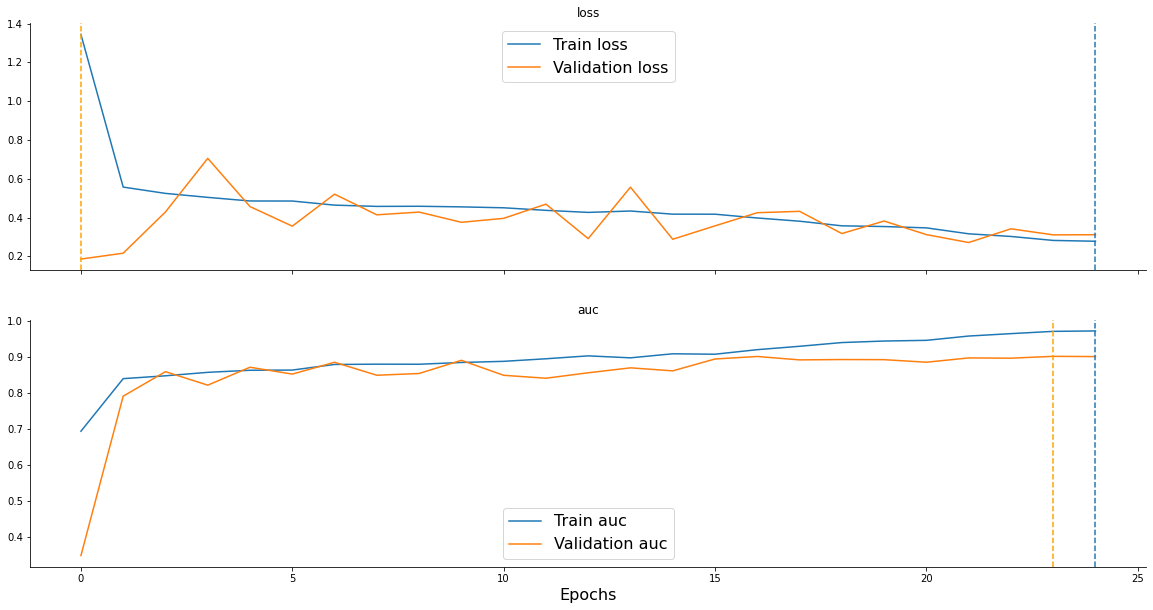

Fold: 2


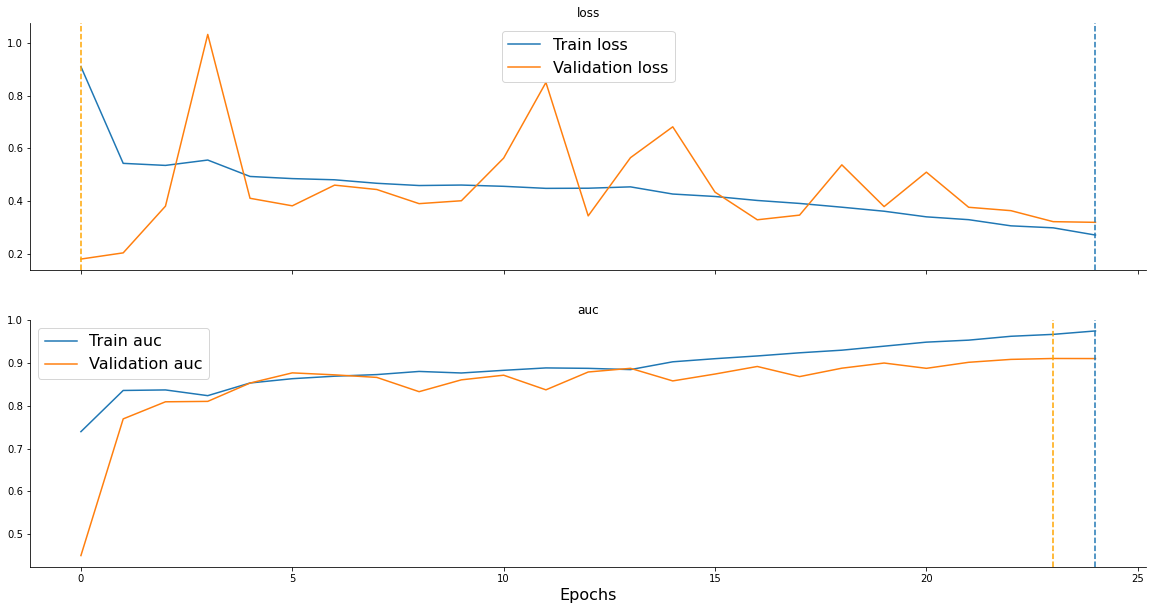

Fold: 3


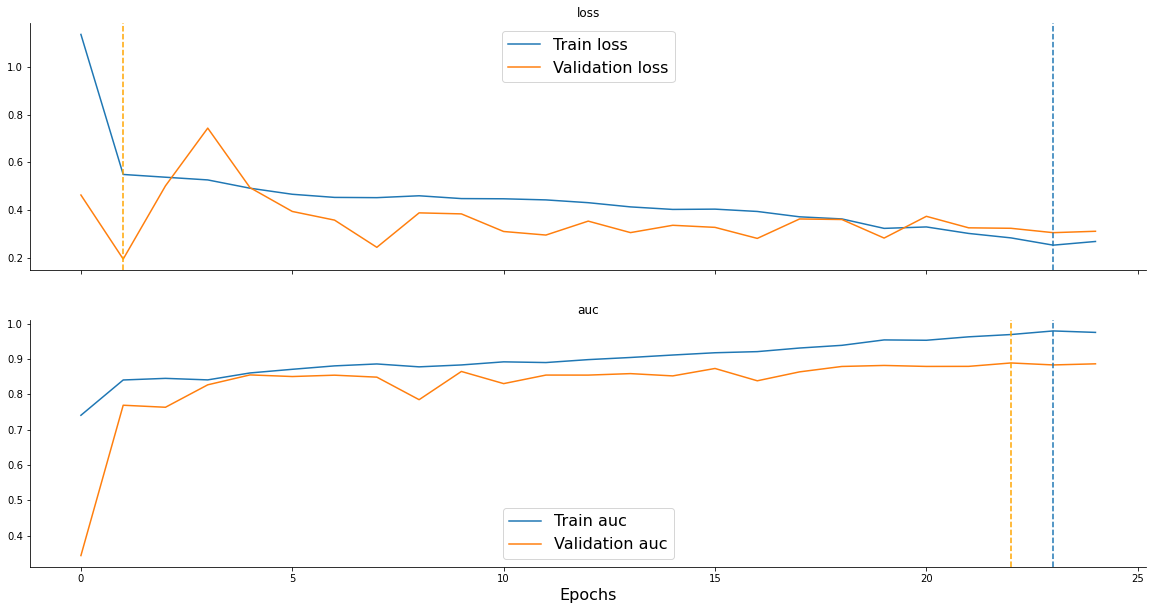

Fold: 4


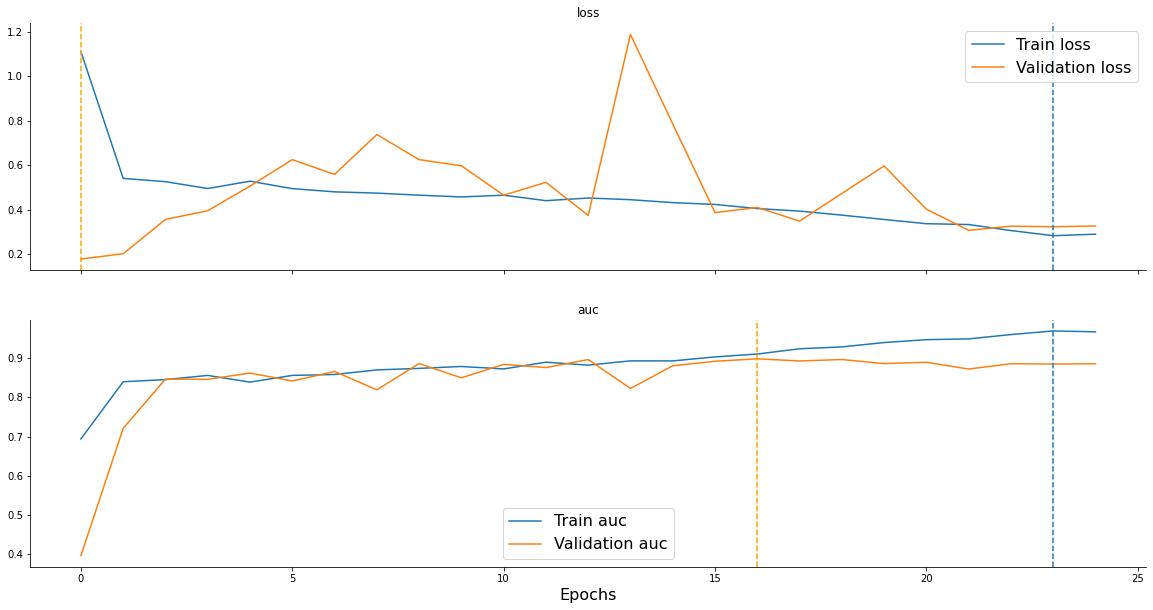

Fold: 5


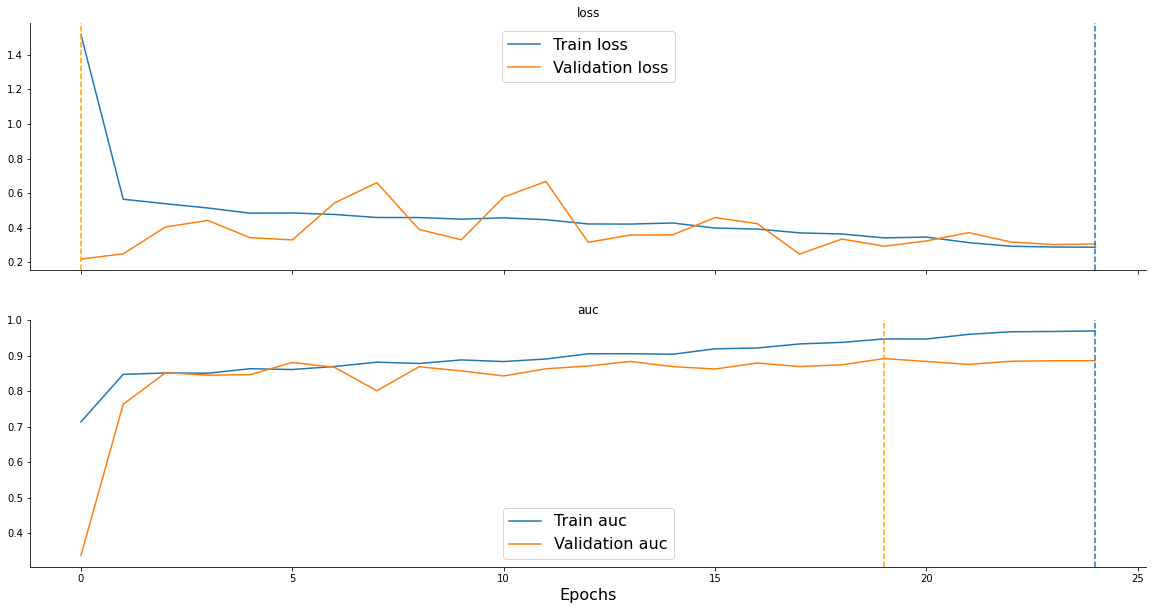

In [12]:
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

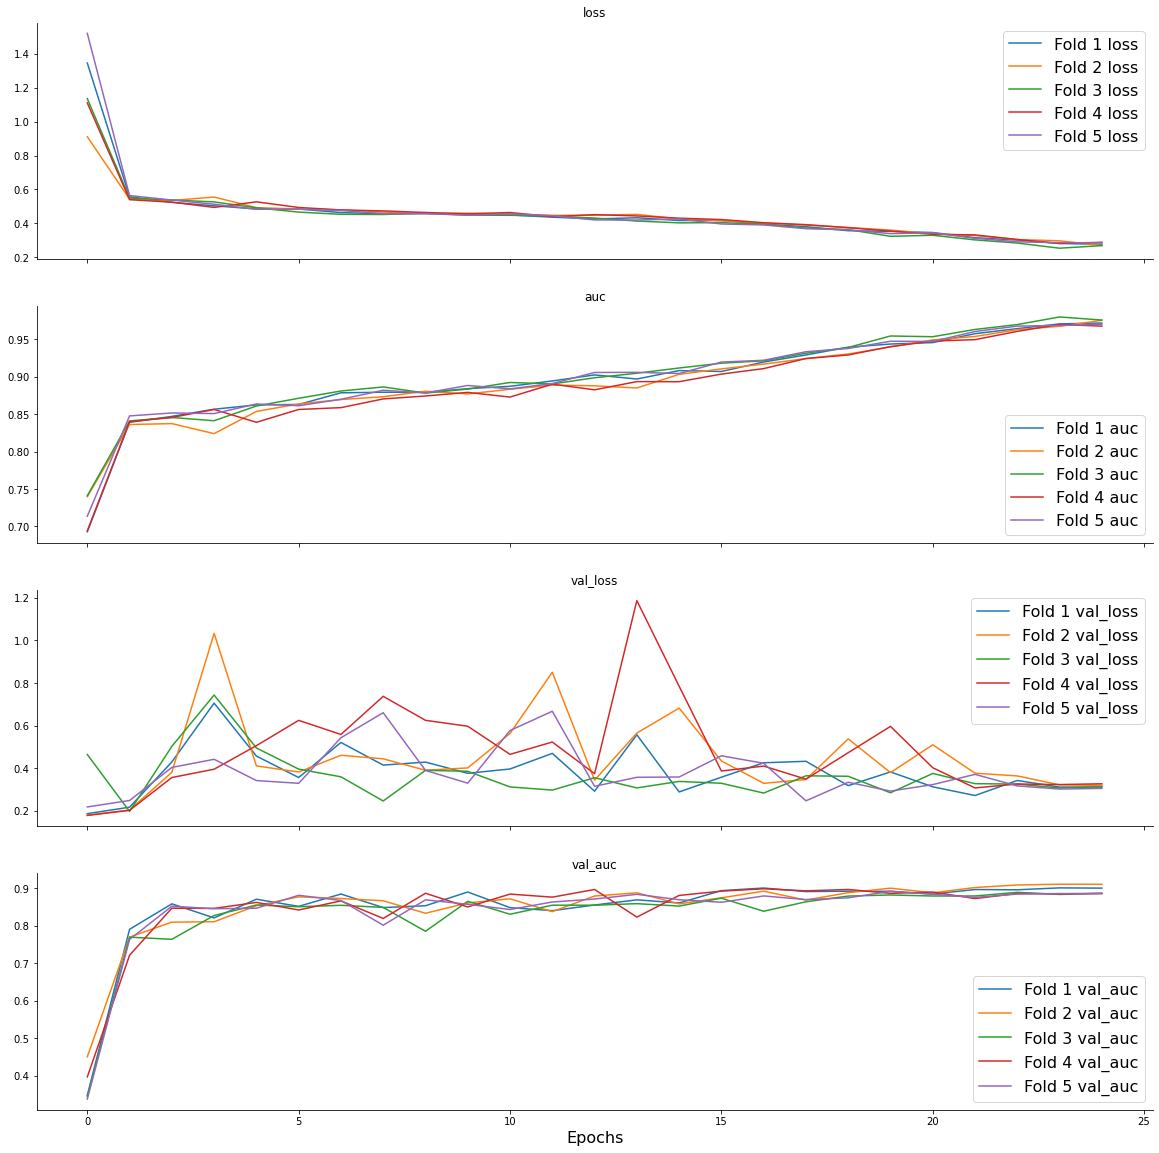

In [13]:
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation (best)

In [14]:
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.974887,0.898184,0.076703,0.986223,0.900636,0.984033,0.911362,0.988358,0.889339,0.947958,0.898684,0.967863,0.890899
Accuracy,0.890620,0.875824,0.014795,0.900898,0.891999,0.903679,0.888480,0.907686,0.884633,0.834327,0.814146,0.906507,0.899863
Precision,0.140889,0.097616,0.043273,0.150788,0.105474,0.153639,0.109834,0.159860,0.099122,0.090370,0.073209,0.149788,0.100443
Recall,0.956533,0.698293,0.258240,0.984979,0.686957,0.980645,0.741379,0.987069,0.675214,0.922246,0.796610,0.907725,0.591304
F1-score,0.244821,0.170574,0.074247,0.261538,0.182870,0.265657,0.191324,0.275158,0.172867,0.164611,0.134094,0.257143,0.171717
Support,464.800000,116.200000,348.600000,466.000000,115.000000,465.000000,116.000000,464.000000,117.000000,463.000000,118.000000,466.000000,115.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.974887,0.898184,0.076703,0.986223,0.900636,0.984033,0.911362,0.988358,0.889339,0.947958,0.898684,0.967863,0.890899
male,0.973354,0.899454,0.073900,0.984293,0.907862,0.985002,0.902552,0.987349,0.869355,0.944667,0.906925,0.965458,0.910574
female,0.975979,0.891331,0.084648,0.988530,0.884725,0.981904,0.918216,0.989232,0.910095,0.950063,0.883987,0.970166,0.859633
head/neck,0.958104,0.868597,0.089507,0.973318,0.820581,0.968679,0.885965,0.979898,0.880769,0.926334,0.852813,0.942288,0.902856
upper extremity,0.974954,0.895807,0.079147,0.987340,0.879372,0.984705,0.914248,0.987198,0.910760,0.935735,0.903248,0.979792,0.871407
lower extremity,0.972699,0.881119,0.091580,0.986307,0.911038,0.979617,0.901480,0.988810,0.848595,0.951886,0.846721,0.956874,0.897761
torso,0.977206,0.908913,0.068293,0.987042,0.917805,0.987230,0.912624,0.989239,0.897083,0.952519,0.922003,0.970000,0.895050
0 <= age < 26,0.953511,0.821464,0.132047,0.976209,0.994169,0.966102,0.837876,0.986813,0.867377,0.903656,0.544118,0.934775,0.863782
26 <= age < 40,0.972170,0.874040,0.098130,0.989234,0.911065,0.983487,0.933988,0.991821,0.812298,0.951070,0.813774,0.945236,0.899073


# Model evaluation (last)

In [15]:
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.985451,0.893971,0.091480,0.986471,0.900026,0.984359,0.910641,0.989034,0.886015,0.982555,0.886941,0.984837,0.886231
Accuracy,0.906401,0.891925,0.014477,0.900363,0.891846,0.905628,0.891241,0.917862,0.896078,0.900038,0.882884,0.908114,0.897573
Precision,0.158410,0.106389,0.052021,0.150098,0.105333,0.156325,0.112418,0.176471,0.105042,0.149283,0.104039,0.159874,0.105114
Recall,0.984089,0.686636,0.297453,0.984979,0.686957,0.980645,0.741379,0.989224,0.641026,0.989201,0.720339,0.976395,0.643478
F1-score,0.272770,0.184185,0.088585,0.260499,0.182659,0.269663,0.195233,0.299511,0.180505,0.259417,0.181818,0.274758,0.180708
Support,464.800000,116.200000,348.600000,466.000000,115.000000,465.000000,116.000000,464.000000,117.000000,463.000000,118.000000,466.000000,115.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.985451,0.893971,0.091480,0.986471,0.900026,0.984359,0.910641,0.989034,0.886015,0.982555,0.886941,0.984837,0.886231
male,0.984258,0.898043,0.086215,0.984523,0.906986,0.985297,0.901908,0.987837,0.868175,0.978862,0.903525,0.984771,0.909624
female,0.986421,0.882490,0.103932,0.988813,0.884167,0.982310,0.917586,0.990226,0.906281,0.986567,0.858478,0.984190,0.845937
head/neck,0.972967,0.856110,0.116857,0.973699,0.822203,0.969082,0.883810,0.981335,0.886686,0.974535,0.818140,0.966186,0.869710
upper extremity,0.985870,0.895316,0.090554,0.987663,0.877808,0.984882,0.914725,0.987803,0.909058,0.981131,0.897539,0.987872,0.877450
lower extremity,0.985637,0.863437,0.122200,0.986507,0.910217,0.980015,0.899441,0.989937,0.844439,0.987464,0.781009,0.984263,0.882080
torso,0.986140,0.911632,0.074509,0.987243,0.917727,0.987558,0.912606,0.989614,0.891658,0.980921,0.945917,0.985366,0.890251
0 <= age < 26,0.978360,0.736811,0.241550,0.976560,0.994169,0.967431,0.835779,0.987728,0.858792,0.980637,0.113445,0.979446,0.881868
26 <= age < 40,0.986745,0.853318,0.133427,0.989403,0.912052,0.983994,0.933663,0.992268,0.785081,0.986469,0.757759,0.981591,0.878037


# Confusion matrix

Fold: 1


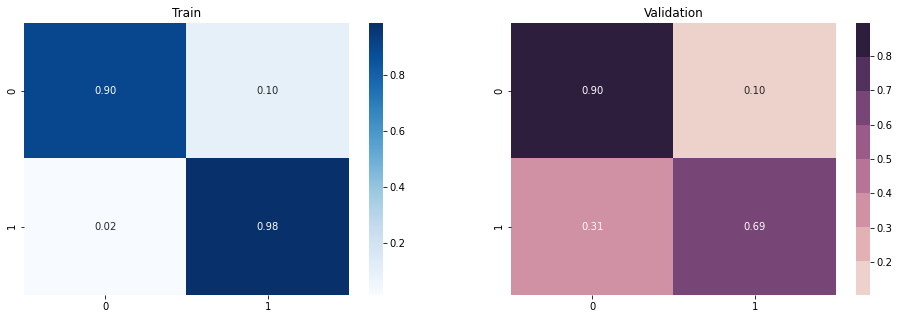

Fold: 2


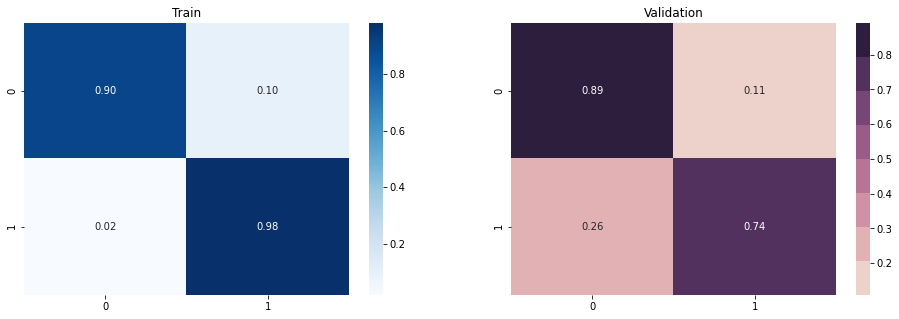

Fold: 3


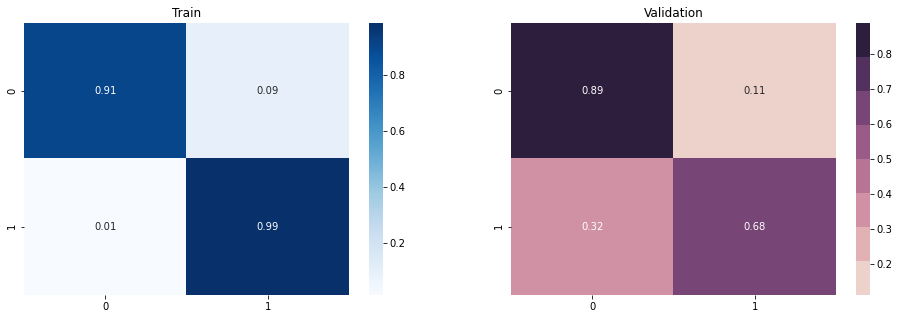

Fold: 4


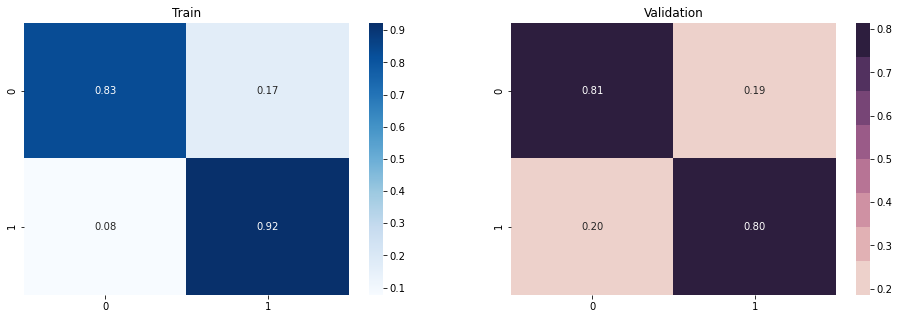

Fold: 5


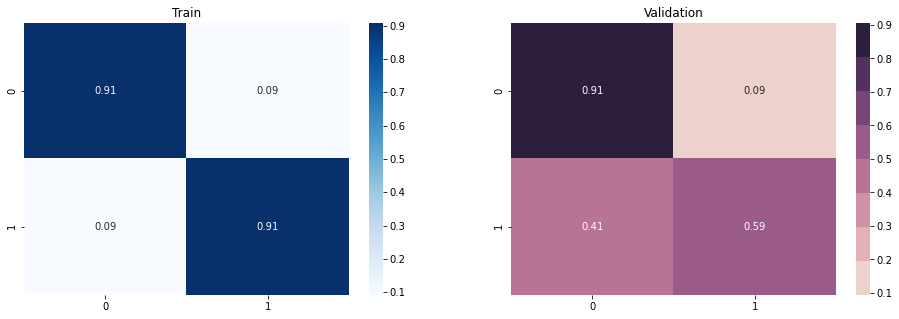

In [16]:
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [17]:
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))

print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 581
Train positive predictions: 3287
Train positive correct predictions: 573
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.013648,0.006171,0.014458,0.018805,0.013865,0.014941
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.009431,0.008316,0.005970,0.007589,0.009587,0.015692
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.012696,0.016733,0.005585,0.011879,0.007671,0.021612
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.069429,0.034770,0.126791,0.047713,0.049392,0.088478
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.008581,0.007605,0.008195,0.009943,0.007400,0.009760
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.035567,0.035579,0.022896,0.055490,0.035687,0.028181
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.037928,0.044977,0.027374,0.032963,0.046076,0.038247
7,ISIC_0075663,female,35.0,torso,unknown,0,0.047823,0.047982,0.079895,0.076888,0.008525,0.025825
8,ISIC_0075914,male,30.0,torso,unknown,0,0.042327,0.053059,0.028646,0.062888,0.032880,0.034164
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.043317,0.030179,0.023317,0.072814,0.053035,0.037239


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.720711,0.981796,0.995438,0.896817,0.714782,0.014724
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.817874,0.852834,0.960587,0.941798,0.880752,0.453398
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.942459,0.946182,0.995238,0.967886,0.813718,0.989271
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.842797,0.915991,0.777449,0.865448,0.728488,0.926611
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.808025,0.963715,0.991322,0.101011,0.987173,0.996903
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.811232,0.934585,0.951684,0.862764,0.388764,0.918364
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.933344,0.963457,0.785170,0.989431,0.994220,0.934440
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.794118,0.877538,0.982107,0.967246,0.858618,0.285082
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.774572,0.892530,0.836050,0.793551,0.582135,0.768593
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.877342,0.982375,0.471436,0.979309,0.991170,0.962421


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
10,ISIC_0076545,male,55.0,upper extremity,unknown,0,0.894437,0.830184,0.957401,0.858480,0.911202,0.914917
42,ISIC_0089738,female,70.0,torso,nevus,0,0.570531,0.722875,0.857608,0.123194,0.708294,0.440682
75,ISIC_0114225,male,80.0,lower extremity,unknown,0,0.539906,0.576424,0.458632,0.646529,0.226529,0.791416
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.720711,0.981796,0.995438,0.896817,0.714782,0.014724
123,ISIC_0159060,male,55.0,head/neck,unknown,0,0.575248,0.266148,0.683587,0.705556,0.945577,0.275370
131,ISIC_0160455,male,75.0,lower extremity,nevus,0,0.548702,0.439526,0.571470,0.596396,0.443482,0.692634
151,ISIC_0165449,male,60.0,torso,unknown,0,0.600032,0.238904,0.750270,0.780025,0.430704,0.800258
158,ISIC_0167093,female,45.0,upper extremity,unknown,0,0.529757,0.797187,0.930931,0.074396,0.563514,0.282757
166,ISIC_0170059,female,60.0,lower extremity,unknown,0,0.903511,0.961910,0.913546,0.810444,0.889704,0.941954
168,ISIC_0170285,female,45.0,upper extremity,unknown,0,0.692617,0.721308,0.832569,0.534557,0.626641,0.748010


# Visualize test predictions

In [18]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 1500|9482
Test predictions (last) 1363|9619
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
0,ISIC_0052060,male,70.0,NaN,0.046980,0.026936
1,ISIC_0052349,male,40.0,lower extremity,0.014915,0.019686
2,ISIC_0058510,female,55.0,torso,0.023350,0.030301
3,ISIC_0073313,female,50.0,torso,0.019099,0.025260
4,ISIC_0073502,female,45.0,lower extremity,0.097349,0.043456
5,ISIC_0074618,male,50.0,lower extremity,0.074538,0.161497
6,ISIC_0076801,male,45.0,upper extremity,0.031039,0.014941
7,ISIC_0077586,male,50.0,lower extremity,0.407703,0.344576
8,ISIC_0082004,female,45.0,torso,0.262682,0.143420
9,ISIC_0082785,male,65.0,lower extremity,0.106449,0.093341


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
22,ISIC_0105104,male,40.0,torso,0.789180,0.850271
24,ISIC_0112420,female,65.0,torso,0.908762,0.931965
42,ISIC_0155983,male,70.0,torso,0.910686,0.902979
56,ISIC_0169906,male,85.0,torso,0.666281,0.658259
57,ISIC_0171865,male,65.0,palms/soles,0.571876,0.601375
61,ISIC_0175798,female,55.0,torso,0.761581,0.810591
64,ISIC_0178235,female,70.0,lower extremity,0.724396,0.724879
69,ISIC_0182213,female,80.0,head/neck,0.749229,0.750926
71,ISIC_0183449,female,60.0,lower extremity,0.915462,0.940143
74,ISIC_0186715,female,35.0,upper extremity,0.680557,0.567197


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
22,ISIC_0105104,male,40.0,torso,0.789180,0.850271
24,ISIC_0112420,female,65.0,torso,0.908762,0.931965
42,ISIC_0155983,male,70.0,torso,0.910686,0.902979
56,ISIC_0169906,male,85.0,torso,0.666281,0.658259
57,ISIC_0171865,male,65.0,palms/soles,0.571876,0.601375
61,ISIC_0175798,female,55.0,torso,0.761581,0.810591
64,ISIC_0178235,female,70.0,lower extremity,0.724396,0.724879
69,ISIC_0182213,female,80.0,head/neck,0.749229,0.750926
71,ISIC_0183449,female,60.0,lower extremity,0.915462,0.940143
74,ISIC_0186715,female,35.0,upper extremity,0.680557,0.567197


# Test set predictions

In [19]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv('submission.csv', index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv('submission_last.csv', index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv('submission_blend.csv', index=False)

,image_name,target,target_last,target_blend
0,ISIC_0052060,0.046980,0.026936,0.036958
1,ISIC_0052349,0.014915,0.019686,0.017301
2,ISIC_0058510,0.023350,0.030301,0.026826
3,ISIC_0073313,0.019099,0.025260,0.022179
4,ISIC_0073502,0.097349,0.043456,0.070403
5,ISIC_0074618,0.074538,0.161497,0.118017
6,ISIC_0076801,0.031039,0.014941,0.022990
7,ISIC_0077586,0.407703,0.344576,0.376139
8,ISIC_0082004,0.262682,0.143420,0.203051
9,ISIC_0082785,0.106449,0.093341,0.099895


,target,target_last,target_blend
count,10982.000000,10982.000000,10982.000000
mean,0.199083,0.176954,0.188018
std,0.238196,0.235982,0.235969
min,0.004164,0.004472,0.005100
25%,0.023510,0.023589,0.024084
50%,0.086204,0.053359,0.070714
75%,0.297625,0.239697,0.267488
max,0.980281,0.985097,0.980797
